## Kaggle Intermediate Machine Learning

## Part 1: Introduction

Exercise: Introduction

Setup

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv('data/train.csv')
X_test_full = pd.read_csv('data/train.csv')

# Obtain target and predictors
y = X_full.SalePrice
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = X_full[features].copy()
X_test = X_test_full[features].copy()

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [5]:
X_train.head()

,LotArea,YearBuilt,1stFlrSF,2ndFlrSF,FullBath,BedroomAbvGr,TotRmsAbvGrd
618,11694,2007,1828,0,2,3,9
870,6600,1962,894,0,1,2,5
92,13360,1921,964,0,1,2,5
817,13265,2002,1689,0,2,3,7
302,13704,2001,1541,0,2,3,6


In [7]:
from sklearn.ensemble import RandomForestRegressor

# Define the models
model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=0)
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=0)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)

models = [model_1, model_2, model_3, model_4, model_5]

To select the best model out of the five, we define a function score_model() below. This function returns the mean absolute error (MAE) from the validation set. Recall that the best model will obtain the lowest MAE.

In [8]:
from sklearn.metrics import mean_absolute_error

# Function for comparing different models
def score_model(model, X_t=X_train, X_v=X_valid, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

for i in range(0, len(models)):
    mae = score_model(models[i])
    print("Model %d MAE: %d" % (i+1, mae))

Model 1 MAE: 24015
Model 2 MAE: 23740
Model 3 MAE: 23528
Model 4 MAE: 23996
Model 5 MAE: 23706


Step 2: Generate test predictions

In [9]:
from sklearn.ensemble import RandomForestRegressor
# Define a model
my_model = RandomForestRegressor(random_state=1) # Your code here
my_model

RandomForestRegressor(random_state=1)

Run the next code cell without changes. The code fits the model to the training and validation data, and then generates test predictions that are saved to a CSV file. These test predictions can be submitted directly to the competition!

In [10]:
# Fit the model to the training data
my_model.fit(X, y)

# Generate test predictions
preds_test = my_model.predict(X_test)

# Save predictions in format used for competition scoring
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

## Part 2: Missing Values

Three Approaches
1) A Simple Option: Drop Columns with Missing Values

2) A Better Option: Imputation: fills in the missing values with some number. For instance, we can fill in the mean value along each column.

3) An Extension To Imputation: In this approach, we impute the missing values, as before. And, additionally, for each column with missing entries in the original dataset, we add a new column that shows the location of the imputed entries.


In [12]:
#Load data
data=pd.read_csv('data/melb_data.csv')

In [15]:
#In the example, we will work with the Melbourne Housing dataset. 
#Our model will use information such as the number of rooms and land size to predict home price.

# Select target
y = data.Price

# To keep things simple, we'll use only numerical predictors
melb_predictors = data.drop(['Price'], axis=1)
X = melb_predictors.select_dtypes(exclude=['object'])#dropping object types

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)

Define Function to Measure Quality of Each Approach

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

**Score from Approach 1 (Drop Columns with Missing Values)** : 183550.22


In [19]:
# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

# Drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

print("MAE from Approach 1 (Drop columns with missing values):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop columns with missing values):
183550.22137772635


**Score from Approach 2 (Imputation):** 178166.46

In [22]:
from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

print("MAE from Approach 2 (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))



MAE from Approach 2 (Imputation):
178166.46269899711


**Score from Approach 3 (An Extension to Imputation):** 178927.50

In [26]:
# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

# Imputation
my_imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

print("MAE from Approach 3 (An Extension to Imputation):")
print(score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid))

MAE from Approach 3 (An Extension to Imputation):
178927.503183954


So, why did imputation perform better than dropping the columns?
The training data has 10864 rows and 12 columns, where three columns contain missing data. For each column, less than half of the entries are missing. Thus, dropping the columns removes a lot of useful information, and so it makes sense that imputation would perform better.

In [27]:
#Shape of training data (num_rows, num_columns)
print(X_train.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(10864, 12)
Car               49
BuildingArea    5156
YearBuilt       4307
dtype: int64


**Exercise: Missing Values**

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv('data/train.csv')

In [38]:
# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# To keep things simple, we'll use only numerical predictors
X = X_full.select_dtypes(exclude=['object'])
X_test = X_test_full.select_dtypes(exclude=['object'])

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [39]:
X_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
618,619,20,90.0,11694,9,5,2007,2007,452.0,48,...,774,0,108,0,0,260,0,0,7,2007
870,871,20,60.0,6600,5,5,1962,1962,0.0,0,...,308,0,0,0,0,0,0,0,8,2009
92,93,30,80.0,13360,5,7,1921,2006,0.0,713,...,432,0,0,44,0,0,0,0,8,2009
817,818,20,NaN,13265,8,5,2002,2002,148.0,1218,...,857,150,59,0,0,0,0,0,7,2008
302,303,20,118.0,13704,7,5,2001,2002,150.0,0,...,843,468,81,0,0,0,0,0,1,2006


Part A

Step 1: Preliminary investigation

In [40]:
# Shape of training data (num_rows, num_columns)
print(X_train.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(1168, 37)
LotFrontage    212
MasVnrArea       6
GarageYrBlt     58
dtype: int64


In [41]:
# Fill in the line below: How many rows are in the training data?
num_rows = 1168

# Fill in the line below: How many columns in the training data
# have missing values?
num_cols_with_missing = 3

# Fill in the line below: How many missing entries are contained in 
# all of the training data?
tot_missing = 212 + 6 + 58

Part B

Considering your answers above, what do you think is likely the best approach to dealing with the missing values?

Step 1:

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

Step 2: Drop columns with missing values


In this step, you'll preprocess the data in `X_train` and `X_valid` to remove columns with missing values.  Set the preprocessed DataFrames to `reduced_X_train` and `reduced_X_valid`, respectively. 

In [45]:
# Fill in the line below: get names of columns with missing values
# Your code here

# Fill in the lines below: drop columns in training and validation data
cols_with_missing = [col for col in X_train.columns
                    if X_train[col].isnull().any()]


reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

In [46]:
missing_val_count_by_column1 = (reduced_X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

#reduced_X_train
reduced_X_valid 

LotFrontage    212
MasVnrArea       6
GarageYrBlt     58
dtype: int64


In [47]:
print("MAE (Drop columns with missing values):")
print(round(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid),2))

MAE (Drop columns with missing values):
17952.59


Step 3: Imputation

Part A

Use the next code cell to impute missing values with the mean value along each column.  Set the preprocessed DataFrames to `imputed_X_train` and `imputed_X_valid`.  Make sure that the column names match those in `X_train` and `X_valid`.

In [49]:
from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer()

# Fill in the lines below: imputation
 # Your code here
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Fill in the lines below: imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

In [50]:
print("MAE (Drop columns with missing values):")
print(round(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid),2))

MAE (Drop columns with missing values):
18250.61


Step 4: Generate test predictions

In this final step, you'll use any approach of your choosing to deal with missing values. Once you've preprocessed the training and validation features, you'll train and evaluate a random forest model. Then, you'll preprocess the test data before generating predictions that can be submitted to the competition!

Part A
Use the next code cell to preprocess the training and validation data. Set the preprocessed DataFrames to final_X_train and final_X_valid. You can use any approach of your choosing here! in order for this step to be marked as correct, you need only ensure:

the preprocessed DataFrames have the same number of columns,
the preprocessed DataFrames have no missing values,
final_X_train and y_train have the same number of rows, and
final_X_valid and y_valid have the same number of rows.

In [58]:
my_imputer=SimpleImputer(strategy='median')
final_X_train=pd.DataFrame(my_imputer.fit_transform(X_train))
final_X_valid=pd.DataFrame(my_imputer.transform(X_valid))

final_X_train.columns=X_train.columns
final_X_valid.columns=X_valid.columns


Run the next code cell to train and evaluate a random forest model. (Note that we don't use the score_dataset() function above, because we will soon use the trained model to generate test predictions!)

In [63]:
# Define and fit model
model=RandomForestRegressor(n_estimators=100,random_state=0)
model.fit(final_X_train, y_train)

# Get validation predictions and MAE

preds_valid=model.predict(final_X_valid)
print("MAE (Your approach):")
print(mean_absolute_error(y_valid, preds_valid))

MAE (Your approach):
18103.602945205483


Part B
Use the next code cell to preprocess your test data. Make sure that you use a method that agrees with how you preprocessed the training and validation data, and set the preprocessed test features to final_X_test.

Then, use the preprocessed test features and the trained model to generate test predictions in preds_test.

In order for this step to be marked correct, you need only ensure:

the preprocessed test DataFrame has no missing values, and
final_X_test has the same number of rows as X_test.

In [65]:
# Fill in the line below: preprocess test data
#final_X_test = pd.DataFrame(my_imputer.transform(X_test))

# Fill in the line below: get test predictions
#preds_test = pd.DataFrame(final_X_test)

## Part 3: Categorical Variables

Three Approaches
1) Drop Categorical Variables
The easiest approach to dealing with categorical variables is to simply remove them from the dataset. This approach will only work well if the columns did not contain useful information.

2) Label Encoding
Label encoding assigns each unique value to a different integer.

3) One-Hot Encoding
One-hot encoding creates new columns indicating the presence (or absence) of each possible value in the original data. To understand this, we'll work through an example.

**Example:**

In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data=pd.read_csv('data/melb_data.csv')

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)



# Drop columns with missing values (simplest approach)
cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()] 
X_train_full.drop(cols_with_missing, axis=1, inplace=True)
X_valid_full.drop(cols_with_missing, axis=1, inplace=True)


# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

X_train.head()

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Landsize,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,0.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,193.0,-37.85800,144.9005,6380.0
8413,h,S,Western Metropolitan,3,12.6,3020.0,3.0,1.0,555.0,-37.79880,144.8220,3755.0
2919,u,SP,Northern Metropolitan,3,13.0,3046.0,3.0,1.0,265.0,-37.70830,144.9158,8870.0
6043,h,S,Western Metropolitan,3,13.3,3020.0,3.0,1.0,673.0,-37.76230,144.8272,4217.0


Next, we obtain a list of all of the categorical variables in the training data.

We do this by checking the data type (or dtype) of each column. The object dtype indicates a column has text (there are other things it could theoretically be, but that's unimportant for our purposes). For this dataset, the columns with text indicate categorical variables.

In [81]:
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Type', 'Method', 'Regionname']


In [82]:
#Define Function to Measure Quality of Each Approach¶

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

**Score from Approach 1 (Drop Categorical Variables)**: 175703.48


In [86]:
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
175703.48185157913


**Score from Approach 2 (Label Encoding)**: 165936.405


Scikit-learn has a LabelEncoder class that can be used to get label encodings. We loop over the categorical variables and apply the label encoder separately to each column.

In [87]:
from sklearn.preprocessing import LabelEncoder

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    label_X_train[col] = label_encoder.fit_transform(X_train[col])
    label_X_valid[col] = label_encoder.transform(X_valid[col])

print("MAE from Approach 2 (Label Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Label Encoding):
165936.40548390493


In the code cell above, for each column, we randomly assign each unique value to a different integer. This is a common approach that is simpler than providing custom labels; however, we can expect an additional boost in performance if we provide better-informed labels for all ordinal variables

**Score from Approach 3 (One-Hot Encoding)** :166089.49

In [85]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE from Approach 3 (One-Hot Encoding):
166089.4893009678


**Exercise: Categorical Variables**

In [96]:
# Read the data
X = pd.read_csv('data/train.csv')
X_test = pd.read_csv('data/train.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

# To keep things simple, we'll drop columns with missing values
cols_with_missing = [col for col in X.columns if X[col].isnull().any()] 
X.drop(cols_with_missing, axis=1, inplace=True)
X_test.drop(cols_with_missing, axis=1, inplace=True)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)


In [97]:
X_train.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
618,619,20,RL,11694,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,108,0,0,260,0,0,7,2007,New,Partial
870,871,20,RL,6600,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,8,2009,WD,Normal
92,93,30,RL,13360,Pave,IR1,HLS,AllPub,Inside,Gtl,...,0,44,0,0,0,0,8,2009,WD,Normal
817,818,20,RL,13265,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,59,0,0,0,0,0,7,2008,WD,Normal
302,303,20,RL,13704,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,81,0,0,0,0,0,1,2006,WD,Normal


In [92]:
# Metric 

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

Step 1: Drop columns with categorical data : 17952.59

You'll get started with the most straightforward approach.  Use the code cell below to preprocess the data in `X_train` and `X_valid` to remove columns with categorical data.  Set the preprocessed DataFrames to `drop_X_train` and `drop_X_valid`, respectively.

In [94]:
drop_X_train = drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
17952.591404109586


In [95]:
print("Unique values in 'Condition2' column in training data:", X_train['Condition2'].unique())
print("\nUnique values in 'Condition2' column in validation data:", X_valid['Condition2'].unique())

Unique values in 'Condition2' column in training data: ['Norm' 'PosA' 'Feedr' 'PosN' 'Artery' 'RRAe']

Unique values in 'Condition2' column in validation data: ['Norm' 'RRAn' 'RRNn' 'Artery' 'Feedr' 'PosN']


Step 2: Label encoding: 17675.94

Part A

If you now write code to: 
- fit a label encoder to the training data, and then 
- use it to transform both the training and validation data, 

you'll get an error.  Can you see why this is the case?  (_You'll need  to use the above output to answer this question._)

In [98]:
# All categorical columns
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely label encoded
good_label_cols = [col for col in object_cols if 
                   set(X_train[col]) == set(X_valid[col])]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be label encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be label encoded: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'BldgType', 'HouseStyle', 'ExterQual', 'CentralAir', 'KitchenQual', 'PavedDrive', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Functional', 'Exterior2nd', 'Neighborhood', 'RoofMatl', 'RoofStyle', 'HeatingQC', 'Heating', 'LandSlope', 'Condition1', 'SaleType', 'Foundation', 'Exterior1st', 'Utilities', 'Condition2', 'ExterCond']


Part B

Use the next code cell to label encode the data in X_train and X_valid. Set the preprocessed DataFrames to label_X_train and label_X_valid, respectively.

We have provided code below to drop the categorical columns in bad_label_cols from the dataset.
You should label encode the categorical columns in good_label_cols.

In [103]:
from sklearn.preprocessing import LabelEncoder

# Drop categorical columns that will not be encoded
label_X_train = X_train.drop(bad_label_cols, axis=1)
label_X_valid = X_valid.drop(bad_label_cols, axis=1)

# Apply label encoder 
label_encoder = LabelEncoder()
for col in set(good_label_cols):
    label_X_train[col] = label_encoder.fit_transform(X_train[col])
    label_X_valid[col] = label_encoder.transform(X_valid[col])  
    
print("MAE from Approach 2 (Label Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Label Encoding):
17675.942500000005


In [104]:
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X_train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('Street', 2),
 ('Utilities', 2),
 ('CentralAir', 2),
 ('LandSlope', 3),
 ('PavedDrive', 3),
 ('LotShape', 4),
 ('LandContour', 4),
 ('ExterQual', 4),
 ('KitchenQual', 4),
 ('MSZoning', 5),
 ('LotConfig', 5),
 ('BldgType', 5),
 ('ExterCond', 5),
 ('HeatingQC', 5),
 ('Condition2', 6),
 ('RoofStyle', 6),
 ('Foundation', 6),
 ('Heating', 6),
 ('Functional', 6),
 ('SaleCondition', 6),
 ('RoofMatl', 7),
 ('HouseStyle', 8),
 ('Condition1', 9),
 ('SaleType', 9),
 ('Exterior1st', 15),
 ('Exterior2nd', 16),
 ('Neighborhood', 25)]

Step 3: Investigating cardinality

Part A

The output above shows, for each column with categorical data, the number of unique values in the column.  For instance, the `'Street'` column in the training data has two unique values: `'Grvl'` and `'Pave'`, corresponding to a gravel road and a paved road, respectively.

We refer to the number of unique entries of a categorical variable as the **cardinality** of that categorical variable.  For instance, the `'Street'` variable has cardinality 2.

Use the output above to answer the questions below

In [106]:
# Fill in the line below: How many categorical variables in the training data
# have cardinality greater than 10?
high_cardinality_numcols = 3

# Fill in the line below: How many columns are needed to one-hot encode the 
# 'Neighborhood' variable in the training data?
num_cols_neighborhood = 25


Part B

One Hot Coding: 

For large datasets with many rows, one-hot encoding can greatly expand the size of the dataset. For this reason, we typically will only one-hot encode columns with relatively low cardinality. Then, high cardinality columns can either be dropped from the dataset, or we can use label encoding.

As an example, consider a dataset with 10,000 rows, and containing one categorical column with 100 unique entries.

If this column is replaced with the corresponding one-hot encoding, how many entries are added to the dataset?
If we instead replace the column with the label encoding, how many entries are added?
Use your answers to fill in the lines below.

In [107]:
# Fill in the line below: How many entries are added to the dataset by 
# replacing the column with a one-hot encoding?
OH_entries_added = 1e4*100 - 1e4

# Fill in the line below: How many entries are added to the dataset by
# replacing the column with a label encoding?
label_entries_added = 0


Next, you'll experiment with one-hot encoding. But, instead of encoding all of the categorical variables in the dataset, you'll only create a one-hot encoding for columns with cardinality less than 10.

Run the code cell below without changes to set low_cardinality_cols to a Python list containing the columns that will be one-hot encoded. Likewise, high_cardinality_cols contains a list of categorical columns that will be dropped from the dataset.

In [108]:
# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 10]

# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be dropped from the dataset:', high_cardinality_cols)

Categorical columns that will be one-hot encoded: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['Exterior1st', 'Neighborhood', 'Exterior2nd']


Step 4: One-hot encoding: 17514.22

Use the next code cell to one-hot encode the data in X_train and X_valid. Set the preprocessed DataFrames to OH_X_train and OH_X_valid, respectively.

The full list of categorical columns in the dataset can be found in the Python list object_cols.
You should only one-hot encode the categorical columns in low_cardinality_cols. All other categorical columns should be dropped from the dataset.

In [111]:
from sklearn.preprocessing import OneHotEncoder

# Use as many lines of code as you need!
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[low_cardinality_cols]))


# One-hot encoding removed index; put it back

OH_cols_train.index=X_train.index
OH_cols_valid.index=X_valid.index



# Remove categorical columns (will replace with one-hot encoding)

num_X_train=X_train.drop(object_cols,axis=1)
num_X_valid=X_valid.drop(object_cols,axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train=pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid=pd.concat([num_X_valid,OH_cols_valid],axis=1)

#Results
print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))



MAE from Approach 3 (One-Hot Encoding):
17514.224246575344


## Part 3: Categorical Variables

Many data scientists hack together models without pipelines, but pipelines have some important benefits. Those include:

Cleaner Code: Accounting for data at each step of preprocessing can get messy. With a pipeline, you won't need to manually keep track of your training and validation data at each step.
Fewer Bugs: There are fewer opportunities to misapply a step or forget a preprocessing step.
Easier to Productionize: It can be surprisingly hard to transition a model from a prototype to something deployable at scale. We won't go into the many related concerns here, but pipelines can help.
More Options for Model Validation: You will see an example in the next tutorial, which covers cross-validation.

Example

In [113]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('data/melb_data.csv')

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_train.head()

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,1.0,0.0,NaN,1940.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,1.0,193.0,NaN,NaN,-37.85800,144.9005,6380.0
8413,h,S,Western Metropolitan,3,12.6,3020.0,3.0,1.0,1.0,555.0,NaN,NaN,-37.79880,144.8220,3755.0
2919,u,SP,Northern Metropolitan,3,13.0,3046.0,3.0,1.0,1.0,265.0,NaN,1995.0,-37.70830,144.9158,8870.0
6043,h,S,Western Metropolitan,3,13.3,3020.0,3.0,1.0,2.0,673.0,673.0,1970.0,-37.76230,144.8272,4217.0


Step 1: Define Preprocessing Steps


Similar to how a pipeline bundles together preprocessing and modeling steps, we use the ColumnTransformer class to bundle together different preprocessing steps. The code below:

imputes missing values in numerical data, and
imputes missing values and applies a one-hot encoding to categorical data.

In [114]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

Step 2: Define the Model
Next, we define a random forest model with the familiar RandomForestRegressor class.

In [115]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=0)

Step 3: Create and Evaluate the Pipeline
Finally, we use the Pipeline class to define a pipeline that bundles the preprocessing and modeling steps. There are a few important things to notice:

With the pipeline, we preprocess the training data and fit the model in a single line of code. (In contrast, without a pipeline, we have to do imputation, one-hot encoding, and model training in separate steps. This becomes especially messy if we have to deal with both numerical and categorical variables!)
With the pipeline, we supply the unprocessed features in X_valid to the predict() command, and the pipeline automatically preprocesses the features before generating predictions. (However, without a pipeline, we have to remember to preprocess the validation data before making predictions.)

In [116]:
from sklearn.metrics import mean_absolute_error

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 160679.18917034855


**Exercise: Pipelines**

In [122]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv('data/train.csv', index_col='Id')
X_test_full = pd.read_csv('data/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

X_train.head()


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
619,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,774,0,108,0,0,260,0,0,7,2007
871,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,PosN,Norm,...,308,0,0,0,0,0,0,0,8,2009
93,RL,Pave,Grvl,IR1,HLS,AllPub,Inside,Gtl,Norm,Norm,...,432,0,0,44,0,0,0,0,8,2009
818,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Norm,Norm,...,857,150,59,0,0,0,0,0,7,2008
303,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,...,843,468,81,0,0,0,0,0,1,2006


The next code cell uses code from the tutorial to preprocess the data and train a model.  Run this code without changes.

In [123]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 17861.780102739725


In [125]:
# Preprocessing for numerical data 
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data 
categorical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore',sparse=False))]) # Your code here 加了parse=False

# Bundle preprocessing for numerical and categorical data 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0) # Your code here


In [126]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 17553.371061643833


Step 2: Generate test predictions

Now, you'll use your trained model to generate predictions with the test data.

In [130]:
preds_test = my_pipeline.predict(X_test)
print(preds_test)

[127226.5  154266.5  184979.12 ... 150508.17 110219.08 222463.  ]


In [129]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

## Part 5: Cross-Validation

In cross-validation, we run our modeling process on different subsets of the data to get multiple measures of model quality.

For example, we could begin by dividing the data into 5 pieces, each 20% of the full dataset. In this case, we say that we have broken the data into 5 "folds".

In [131]:
data=pd.read_csv('data/melb_data.csv')

# Select subset of predictors
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = data[cols_to_use]

# Select target
y = data.Price

In [132]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

#Pipeline 
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestRegressor(n_estimators=50,
                                                              random_state=0))
                             ])

In [133]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

MAE scores:
 [301628.7893587  303164.4782723  287298.331666   236061.84754543
 260383.45111427]


The scoring parameter chooses a measure of model quality to report: in this case, we chose negative mean absolute error (MAE). The docs for scikit-learn show a list of options.

It is a little surprising that we specify negative MAE. Scikit-learn has a convention where all metrics are defined so a high number is better. Using negatives here allows them to be consistent with that convention, though negative MAE is almost unheard of elsewhere.

We typically want a single measure of model quality to compare alternative models. So we take the average across experiments.

In [134]:
print("Average MAE score (across experiments):")
print(scores.mean())

Average MAE score (across experiments):
277707.3795913405


**Exercise: Cross-Validation**

In [139]:
import pandas as pd
from sklearn.model_selection import train_test_split


# Read the data
train_data = pd.read_csv('data/train.csv', index_col='Id')
test_data = pd.read_csv('data/train.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = train_data.SalePrice              
train_data.drop(['SalePrice'], axis=1, inplace=True)

# Select numeric columns only
numeric_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]
X = train_data[numeric_cols].copy()
X_test = test_data[numeric_cols].copy()

X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


Our model and pipeline

In [140]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

my_pipeline = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),
    ('model', RandomForestRegressor(n_estimators=50, random_state=0))
])

You have also learned how to use pipelines in cross-validation.  The code below uses the [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function to obtain the mean absolute error (MAE), averaged across five different folds.  Recall we set the number of folds with the `cv` parameter.

In [142]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("Average MAE score:", scores.mean())

Average MAE score: 18276.410356164386


Step 1: Write a useful function
In this exercise, you'll use cross-validation to select parameters for a machine learning model.

Begin by writing a function get_score() that reports the average (over three cross-validation folds) MAE of a machine learning pipeline that uses:

the data in X and y to create folds,
SimpleImputer() (with all parameters left as default) to replace missing values, and
RandomForestRegressor() (with random_state=0) to fit a random forest model.
The n_estimators parameter supplied to get_score() is used when setting the number of trees in the random forest model.

In [145]:
def get_score(n_estimators):
    """Return the average MAE over 3 CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    # Replace this body with your own code
    
    my_pipeline=Pipeline(steps=
                         [('preprocessor', SimpleImputer()), 
                          ('model',RandomForestRegressor(n_estimators,random_state=0))])
    scores=-1*cross_val_score(my_pipeline,X,y, cv=3, scoring='neg_mean_absolute_error')
    return scores.mean()
    


In [144]:
results = {}

for i in range(1,9):
    results[50*i] = get_score(50*i)

Plotting results 

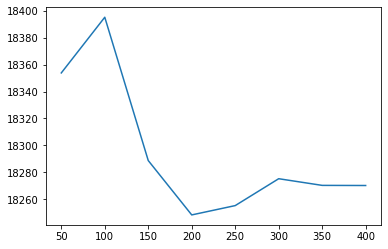

In [146]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

Step 3: Find the best parameter value
Given the results, which value for n_estimators seems best for the random forest model? Use your answer to set the value of n_estimators_best.

In [148]:
n_estimators_best = min(results, key=results.get) 
print(n_estimators_best)

200


## Part 6: Cross-Validation

Gradient Boosting
Gradient boosting is a method that goes through cycles to iteratively add models into an ensemble.

**Farrukh Bulbulov**